In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import folium # map rendering library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'R030EXAUPY15DEW1PRLWP5NUUJ0SOPXUVLUI5ANX2NM5F5KG' # your Foursquare ID
    CLIENT_SECRET = 'TBK2214FRNELZJ2LGTHTYKFN5OUZK30DF3GWOMUCP55ICW3T' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'R030EXAUPY15DEW1PRLWP5NUUJ0SOPXUVLUI5ANX2NM5F5KG' # your Foursquare ID
    CLIENT_SECRET = 'TBK2214FRNELZJ2LGTHTYKFN5OUZK30DF3GWOMUCP55ICW3T'# your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
# get new york data
new_york_data=get_new_york_data()

In [7]:
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
new_york_data.shape

(306, 4)

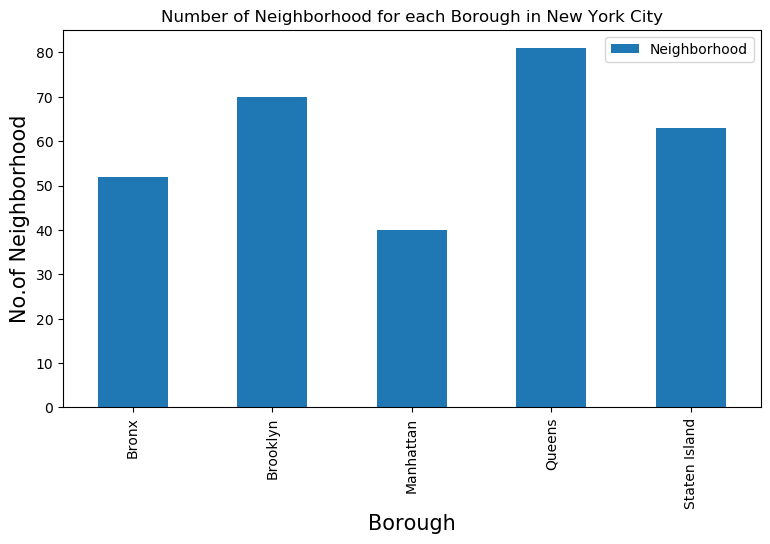

In [9]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighborhood for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [11]:
# prepare neighborhood list that contains italian restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
italian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    italian_restaurants=venues[venues['Category']=='Italian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Italian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(italian_restaurants)))
    for restaurant_detail in italian_restaurants.values.tolist():
        id, name , category=restaurant_detail
        italian_rest_ny = italian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Italian Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Italian Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Italian Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Italian Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Italian Restaurants in Riverdale, Bronx:1
( 6 / 306 ) Italian Restaurants in Kingsbridge, Bronx:1
( 7 / 306 ) Italian Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Italian Restaurants in Woodlawn, Bronx:2
( 9 / 306 ) Italian Restaurants in Norwood, Bronx:0
( 10 / 306 ) Italian Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Italian Restaurants in Baychester, Bronx:2
( 12 / 306 ) Italian Restaurants in Pelham Parkway, Bronx:3
( 13 / 306 ) Italian Restaurants in City Island, Bronx:3
( 14 / 306 ) Italian Restaurants in Bedford Park, Bronx:1
( 15 / 306 ) Italian Restaurants in University Heights, Bronx:0
( 16 / 306 ) Italian Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Italian Restaurants in Fordham, Bronx:9
( 18 / 306 ) Italian Restaurants in Ea

KeyError: 'groups'

In [12]:
italian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's


In [13]:
italian_rest_ny.shape

(327, 4)

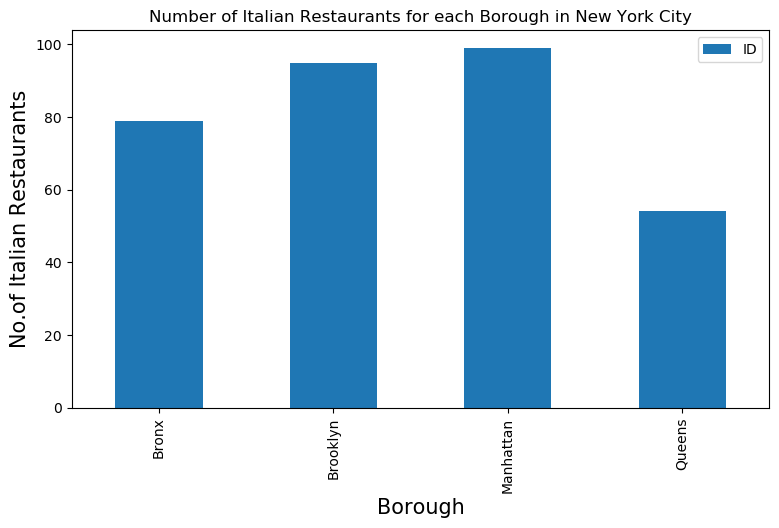

In [14]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

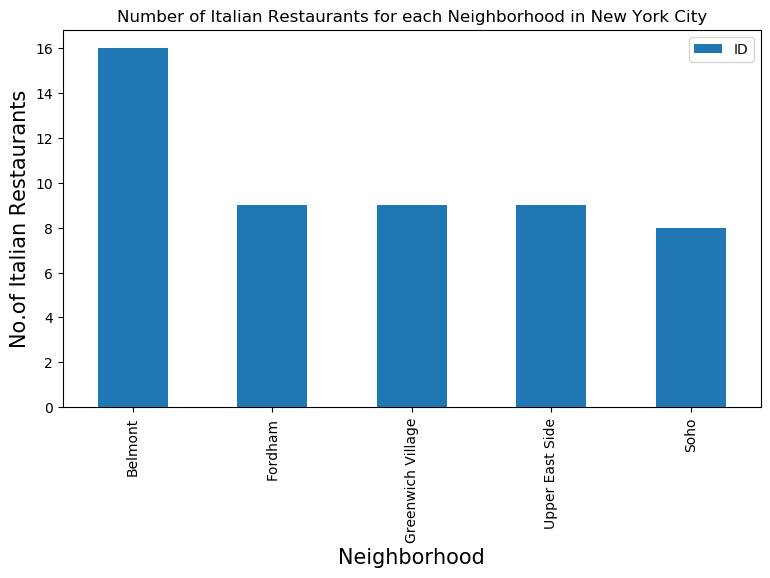

In [15]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Italian Restaurants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Italian Restaurants', fontsize=15)
#giving a bar plot
italian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [16]:
italian_rest_ny[italian_rest_ny['Neighborhood']=='Belmont']

,Borough,Neighborhood,ID,Name
44,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
45,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
46,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
47,Bronx,Belmont,4a8e261cf964a5201c1220e3,Roberto's
48,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
49,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant
50,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
51,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
52,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
53,Bronx,Belmont,4bc22a22920eb713bcc51b2c,Tra Di Noi


In [17]:
# prepare neighborhood list that contains italian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
italian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in italian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(italian_rest_ny),')','processed')
    italian_rest_stats_ny = italian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 1 / 327 ) processed
                         ID                  Name  Likes  Rating  Tips
0  55aaee4d498e3cbb70e625d6  Bella Notte Pizzeria      9     6.8     4
( 2 / 327 ) processed
                         ID                    Name  Likes  Rating  Tips
0  511edb6de4b0d58346fd272d  Patrizia's Of Woodlawn     18     8.6    14
( 3 / 327 ) processed
                         ID         Name  Likes  Rating  Tips
0  4d3cb3026b3d236a066a6364  Rivers Edge     10     6.9     8
( 4 / 327 ) processed
                         ID        Name  Likes  Rating  Tips
0  4c9518076b35a143d5dc21dc  Fratelli's     22     8.7     6
( 5 / 327 ) processed
                         ID          Name  Likes  Rating  Tips
0  5411894d498e4a254a11a46c  Olive Garden     26     7.3     8
( 6 / 327 ) processed
                         ID    Name  Likes  Rating  Tips
0  4bf96a

KeyError: 'venue'

In [18]:
italian_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.6,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.9,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.7,6


In [19]:
italian_rest_stats_ny.shape

(50, 7)

In [20]:
italian_rest_ny.shape

(327, 4)

In [21]:
italian_rest_stats_ny.to_csv('italian_rest_stats_ny.csv', index=False)

In [22]:
italian_rest_stats_ny_csv=pd.read_csv('italian_rest_stats_ny.csv')

In [23]:
italian_rest_stats_ny_csv.shape

(50, 7)

In [24]:
italian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Riverdale,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
1,Bronx,Kingsbridge,55aaee4d498e3cbb70e625d6,Bella Notte Pizzeria,9,6.8,4
2,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.6,14
3,Bronx,Woodlawn,4d3cb3026b3d236a066a6364,Rivers Edge,10,6.9,8
4,Bronx,Baychester,4c9518076b35a143d5dc21dc,Fratelli's,22,8.7,6


In [25]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     object 
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     object 
dtypes: float64(1), object(6)
memory usage: 2.9+ KB


In [26]:
italian_rest_stats_ny['Likes']=italian_rest_stats_ny['Likes'].astype('float64')

In [27]:
italian_rest_stats_ny['Tips']=italian_rest_stats_ny['Tips'].astype('float64')

In [28]:
italian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       50 non-null     object 
 1   Neighborhood  50 non-null     object 
 2   ID            50 non-null     object 
 3   Name          50 non-null     object 
 4   Likes         50 non-null     float64
 5   Rating        50 non-null     float64
 6   Tips          50 non-null     float64
dtypes: float64(3), object(4)
memory usage: 2.9+ KB


In [29]:
# Resturant with maximum Likes
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Likes'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                176
Rating                               8.2
Tips                                  72
Name: 37, dtype: object

In [30]:
# Resturant with maximum Rating
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                     Fordham
ID              4acf80aef964a52025d420e3
Name                 Tino's Delicatessen
Likes                                145
Rating                               9.2
Tips                                  48
Name: 13, dtype: object

In [31]:
# Resturant with maximum Tips
italian_rest_stats_ny.iloc[italian_rest_stats_ny['Tips'].idxmax()]

Borough                            Bronx
Neighborhood                    Van Nest
ID              3fd66200f964a5207bf11ee3
Name                   F & J Pine Tavern
Likes                                176
Rating                               8.2
Tips                                  72
Name: 37, dtype: object

In [32]:
ny_neighborhood_stats=italian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [33]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
2,Belmont,8.600000
9,Morrisania,8.200000
5,Fordham,8.077778
0,Baychester,8.000000
14,Van Nest,7.800000
16,Woodlawn,7.750000
11,Pelham Parkway,7.733333
7,Melrose,7.700000
3,City Island,7.533333
8,Morris Park,7.500000


In [34]:
ny_borough_stats=italian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [35]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,7.544


In [36]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Baychester,8.000000
2,Belmont,8.600000
5,Fordham,8.077778
9,Morrisania,8.200000


In [37]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,8.000000
1,Bronx,Belmont,40.857277,-73.888452,8.600000
2,Bronx,Fordham,40.860997,-73.896427,8.077778
3,Bronx,Morrisania,40.823592,-73.901506,8.200000


In [40]:
import folium # map rendering library
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge geopy --yes
import geocoder
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    click-7.1.2                |     pyh9f0ad1d_0          64 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    future-0.18.2              |   py36h9f0ad1d_1         714 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    idna-2.10                  |     pyh9f0ad1d_0          52 KB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    r

In [41]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)


# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [42]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [43]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(incidents)